In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.Flowers102(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(texts_list):
    with torch.no_grad():
        label_ids = []
        text_features_cuda = []
        cls_features_cuda = []
        for label_id, texts in texts_list.items():
            label_ids.append([label_id] * len(texts))
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        text_features = torch.vstack(text_features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, text_features, text_features_cuda, cls_features_cuda, masked_similarity

In [10]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create template text features
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(template_label_texts_list)

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [12]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'bromelia': ['bromeliads'],
}

In [13]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 1 prompts for (0)pink primrose
["I'm not sure what you are asking."]

Filtered 1 prompts for (4)english marigold
['Look for a plant with showy, fragrant yellow, orange, or red flowers.']

Filtered 1 prompts for (5)tiger lily
['.']

Filtered 1 prompts for (9)globe thistle
['.']

Filtered 1 prompts for (15)globe-flower
[' that grows naturally in Europe.']

Filtered 2 prompts for (19)giant white arum lily
['.', '.']

Filtered 1 prompts for (25)corn poppy
['.']

Filtered 3 prompts for (26)prince of wales feathers
['The flower is characterized by long, narrow leaves with a silvery-white downy coating.', 'I am not sure what you are asking.', "I'm not sure what you are asking."]

Filtered 1 prompts for (28)artichoke
[', in the wildArtichokes are thistle-like flowers that grow in clusters.']

Filtered 1 prompts for (31)garden phlox
['.']

Filtered 1 prompts for (32)love in the mist
['Look for a flower with a delicate, lacy appearance.']

Filtered 3 prompts for (37)great masterwort
['.

In [14]:
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create original gpt3 text features
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(filtered_gpt3_label_texts_list)

In [15]:
from collections import defaultdict

imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)

In [16]:
# Create image features
with torch.no_grad():
    img_label_ids = []
    img_features_cuda = []
    img_cls_features_cuda = []
    img_cls_name_similarity_cuda = []
    img_template_cls_similarity_cuda = []
    img_template_text_similarity_cuda = []
    img_original_gpt3_cls_similarity_cuda = []
    img_original_gpt3_text_similarity_cuda = []
    img_filtered_gpt3_cls_similarity_cuda = []
    img_filtered_gpt3_text_similarity_cuda = []
    for label_id, imgs in tqdm(imgs_grouped.items()):
        img_label_ids.append([label_id] * len(imgs))
        imgs = torch.stack([preprocess(img) for img in imgs]).to(device)
        img_embeddings = model.encode_image(imgs)
        img_embeddings /= img_embeddings.norm(dim=-1, keepdim=True)
        img_embedding = img_embeddings.mean(dim=0)
        img_embedding /= img_embedding.norm()
        img_features_cuda.append(img_embeddings)
        img_cls_features_cuda.append(img_embedding)
        # mean by cls then mul
        img_cls_name_similarity_cuda.append((img_embeddings @ cls_name_features_cuda.T).mean(dim=0))
        img_template_cls_similarity_cuda.append((img_embeddings @ template_cls_features_cuda.T).mean(dim=0))
        img_original_gpt3_cls_similarity_cuda.append((img_embeddings @ original_gpt3_cls_features_cuda.T).mean(dim=0))
        img_filtered_gpt3_cls_similarity_cuda.append((img_embeddings @ filtered_gpt3_cls_features_cuda.T).mean(dim=0))
        # mul then mean by cls
        img_template_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in template_text_features_cuda]))
        img_original_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in original_gpt3_text_features_cuda]))
        img_filtered_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in filtered_gpt3_text_features_cuda]))
    img_label_ids = np.hstack(img_label_ids)
    img_features_cuda = torch.vstack(img_features_cuda)
    img_features = img_features_cuda.cpu().numpy()
    img_cls_features_cuda = torch.vstack(img_cls_features_cuda)
    # mean by cls then mul
    img_cls_name_similarity = torch.vstack(img_cls_name_similarity_cuda).cpu().numpy()
    img_template_cls_similarity = torch.vstack(img_template_cls_similarity_cuda).cpu().numpy()
    img_original_gpt3_cls_similarity = torch.vstack(img_original_gpt3_cls_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_cls_similarity = torch.vstack(img_filtered_gpt3_cls_similarity_cuda).cpu().numpy()
    # mul then mean by cls
    img_template_text_similarity = torch.vstack(img_template_text_similarity_cuda).cpu().numpy()
    img_original_gpt3_text_similarity = torch.vstack(img_original_gpt3_text_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_text_similarity = torch.vstack(img_filtered_gpt3_text_similarity_cuda).cpu().numpy()

    # Fill diagonal for better visibility
    img_masked_similarity = (img_cls_features_cuda @ img_cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

100%|██████████| 102/102 [00:30<00:00,  3.36it/s]


In [17]:
# Zero-shot classification using CLIP
with torch.no_grad():
    logits_cls_name_cuda = img_features_cuda @ cls_name_features_cuda.T
    logits_template_cls_cuda = img_features_cuda @ template_cls_features_cuda.T
    logits_original_gpt3_cls_cuda = img_features_cuda @ original_gpt3_cls_features_cuda.T
    logits_filtered_gpt3_cls_cuda = img_features_cuda @ filtered_gpt3_cls_features_cuda.T

    pred_cls_name = logits_cls_name_cuda.argmax(dim=-1).cpu().numpy()
    pred_template_cls = logits_template_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_original_gpt3_cls = logits_original_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_filtered_gpt3_cls = logits_filtered_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()

    correct_cls_name = (pred_cls_name == img_label_ids).mean()
    correct_template_cls = (pred_template_cls == img_label_ids).mean()
    correct_original_gpt3 = (pred_original_gpt3_cls == img_label_ids).mean()
    correct_filtered_gpt3 = (pred_filtered_gpt3_cls == img_label_ids).mean()

In [18]:
print(f'Accuracy of CLIP with class names: {correct_cls_name*100:.2f}%')
print(f'Accuracy of CLIP with text template: {correct_template_cls*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text: {correct_original_gpt3*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text: {correct_filtered_gpt3*100:.2f}%')

Accuracy of CLIP with class names: 64.80%
Accuracy of CLIP with text template: 65.90%
Accuracy of CLIP with original GPT-3 text: 73.81%
Accuracy of CLIP with filtered GPT-3 text: 74.02%


In [19]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}')

In [20]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [21]:
def visualize_auto_similarity(masked_similarity, title):
    print(f'{title.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_similarity(np.triu(masked_similarity, k=1))
    plot_similarity(masked_similarity, title)

In [22]:
def visualize_cross_similarity(similarity, title, xlabel='Text', ylabel='Image'):
    print(f'{title.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_similarity(similarity, top=20)
    plot_similarity(similarity, title, xlabel=xlabel, ylabel=ylabel)

Class name similarity mean: 0.56787109375
Class name similarity std: 0.0955810546875
Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, Similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, Similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, Similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, Similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, Similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, Similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, Similarity: 0.8251953125


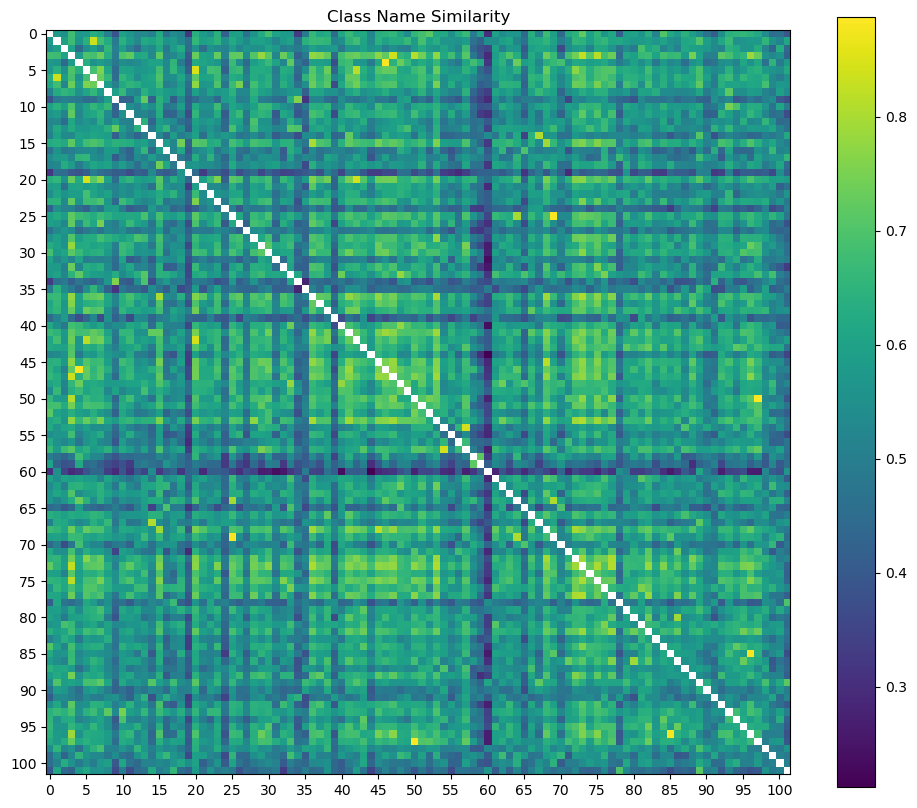

Text template similarity mean: 0.5830078125
Text template similarity std: 0.0941162109375
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, Similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, Similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, Similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, Similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, Similarity: 0.8447265625


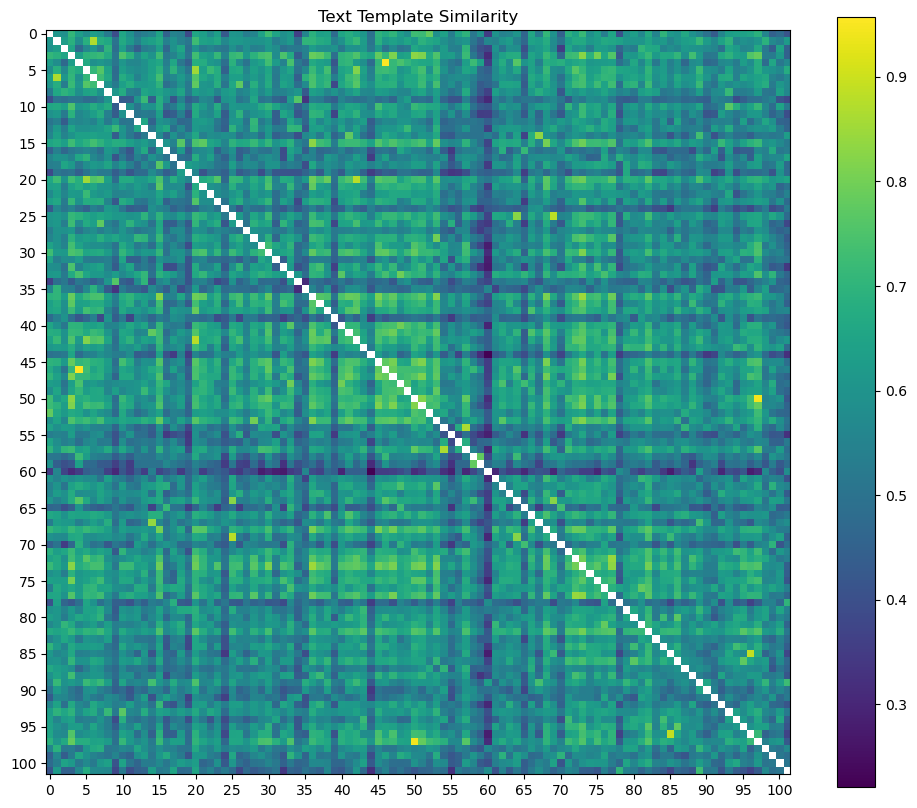

Original gpt-3 text similarity mean: 0.603515625
Original gpt-3 text similarity std: 0.086669921875
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.978515625
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.94677734375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8984375
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8955078125
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.89501953125
Rank 8: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, Similarity: 0.888671875
Rank 10: (20)fire lily - (42)sword lily, Similarity: 0.8818359375


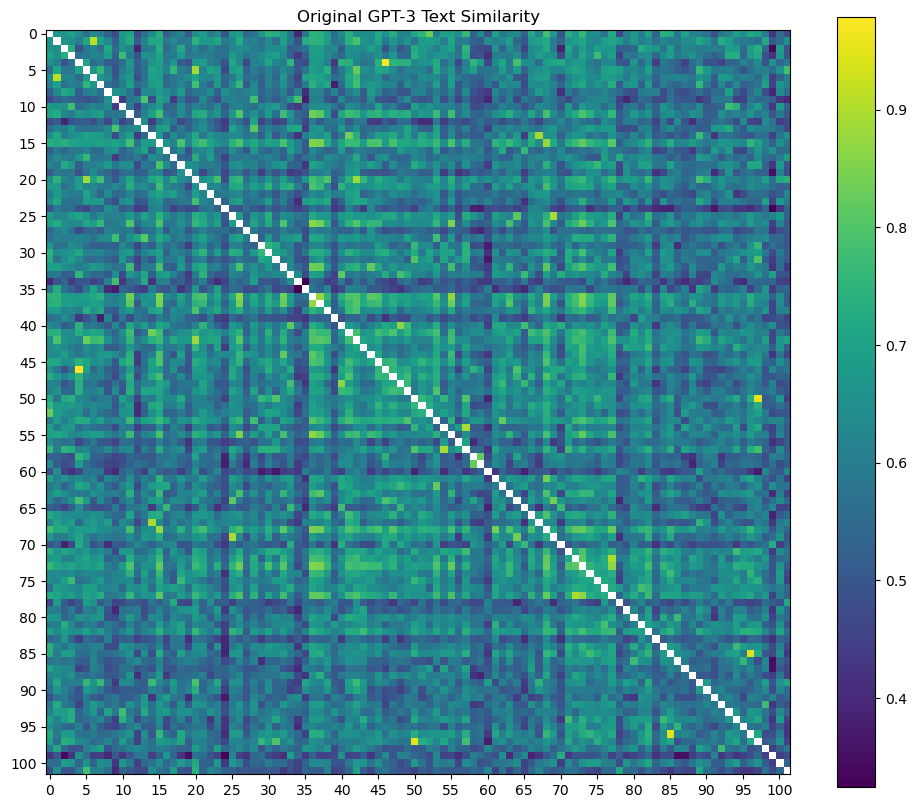

Filtered gpt-3 text similarity mean: 0.5966796875
Filtered gpt-3 text similarity std: 0.08856201171875
Rank 1: (4)english marigold - (46)marigold, Similarity: 0.97705078125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8935546875
Rank 7: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 8: (54)pelargonium - (57)geranium, Similarity: 0.8876953125
Rank 9: (20)fire lily - (42)sword lily, Similarity: 0.8818359375
Rank 10: (5)tiger lily - (20)fire lily, Similarity: 0.880859375


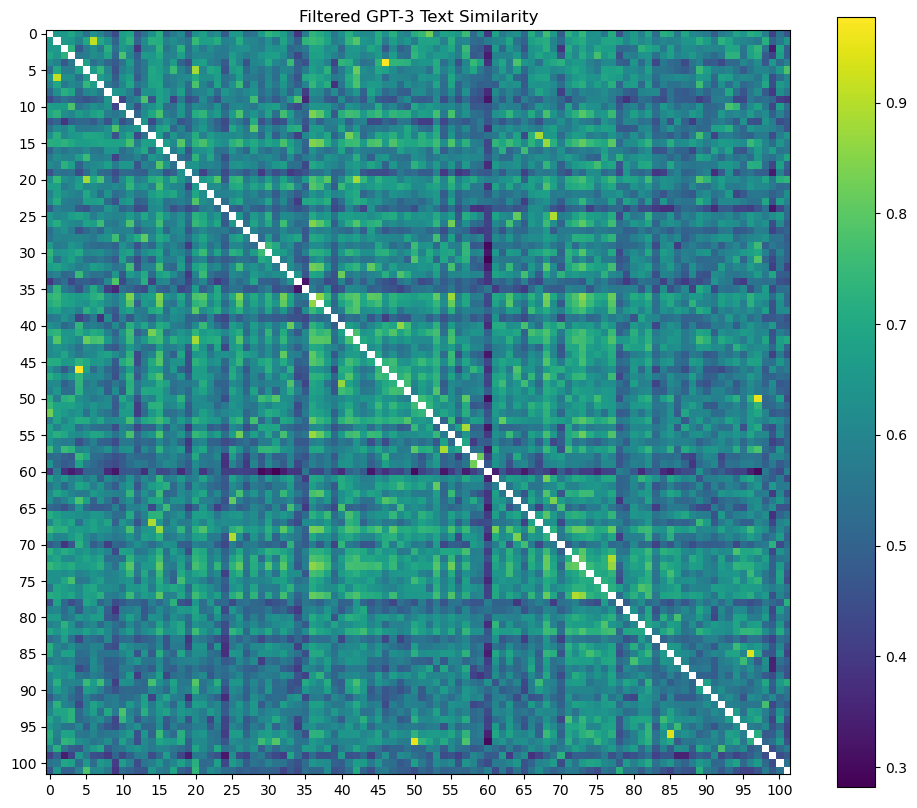

In [23]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name Similarity')
visualize_auto_similarity(template_masked_similarity, 'Text Template Similarity')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text Similarity')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text Similarity')

Image similarity mean: 0.85791015625
Image similarity std: 0.04010009765625
Rank 1: (1)hard-leaved pocket orchid - (11)colt's foot, Similarity: 0.97998046875
Rank 2: (32)love in the mist - (69)tree poppy, Similarity: 0.97265625
Rank 3: (14)yellow iris - (48)oxeye daisy, Similarity: 0.9716796875
Rank 4: (14)yellow iris - (38)siam tulip, Similarity: 0.9697265625
Rank 5: (38)siam tulip - (48)oxeye daisy, Similarity: 0.96923828125
Rank 6: (38)siam tulip - (99)blanket flower, Similarity: 0.9677734375
Rank 7: (15)globe-flower - (37)great masterwort, Similarity: 0.966796875
Rank 8: (48)oxeye daisy - (99)blanket flower, Similarity: 0.96240234375
Rank 9: (14)yellow iris - (54)pelargonium, Similarity: 0.9609375
Rank 10: (23)red ginger - (56)gaura, Similarity: 0.9599609375


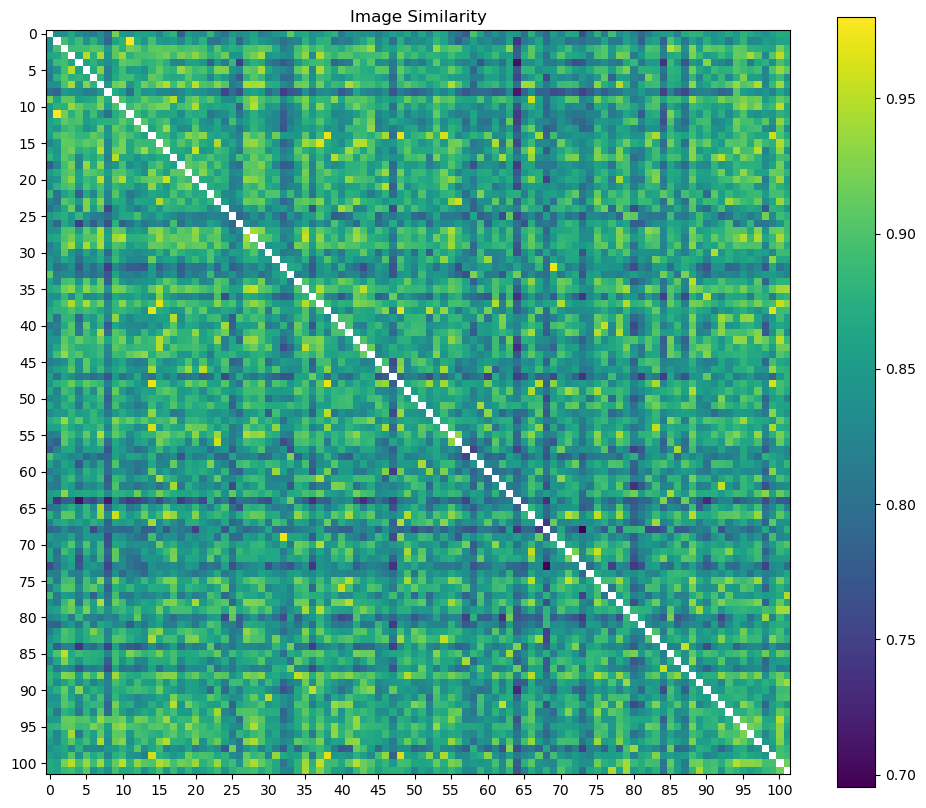

Image to class name similarity mean: 0.21630859375
Image to class name similarity std: 0.035491943359375
Image to class name similarity diagonal mean: 0.224853515625
Image to class name similarity diagonal std: 0.04608154296875
Image to class name similarity non-diagonal mean: 0.21630859375
Image to class name similarity non-diagonal std: 0.035369873046875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.0390625
Rank 1: (68)windflower - (60)cautleya spicata, Similarity: 0.3564453125
Rank 2: (74)thorn apple - (24)grape hyacinth, Similarity: 0.3486328125
Rank 3: (77)lotus - (78)toad lily, Similarity: 0.34765625
Rank 4: (45)wallflower - (4)english marigold, Similarity: 0.34521484375
Rank 5: (12)king protea - (79)anthurium, Similarity: 0.34423828125
Rank 6: (39)lenten rose - (39)lenten rose, Similarity: 0.343505859375
Rank 7: (58)orange dahlia - (12)king protea, Similarity: 0.34326171875
Rank 8: (8)monkshood - (43)poinsettia, Similarity: 0.342529296875
Rank 9: (69

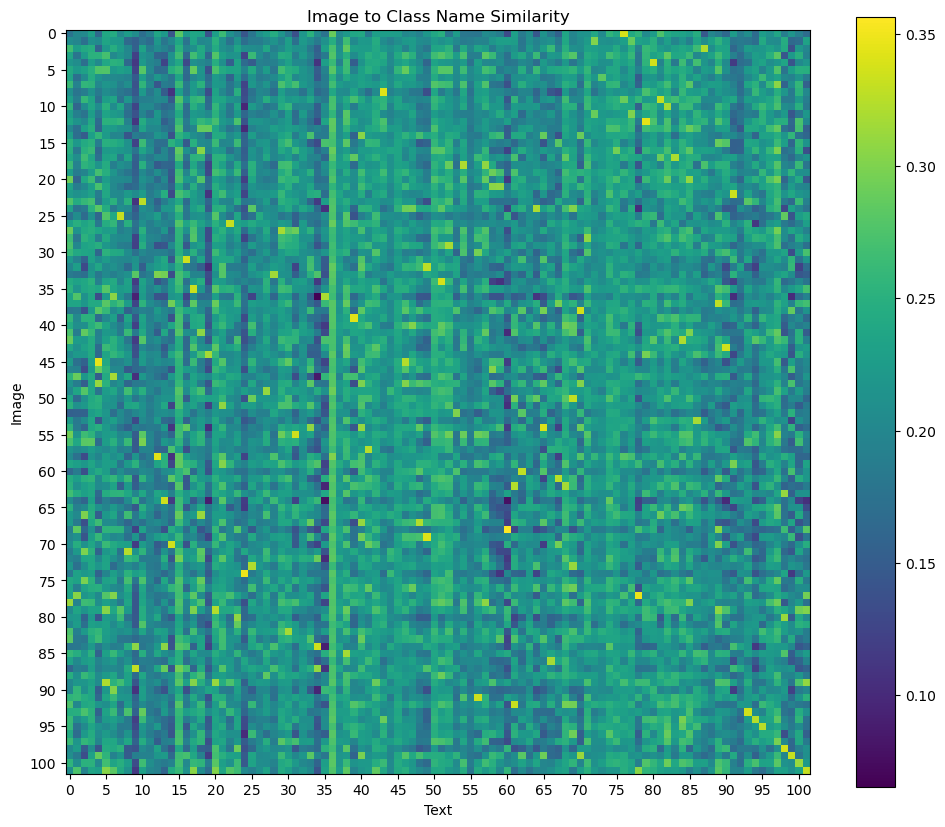

Image to text template similarity mean: 0.230224609375
Image to text template similarity std: 0.037841796875
Image to text template similarity diagonal mean: 0.23974609375
Image to text template similarity diagonal std: 0.048583984375
Image to text template similarity non-diagonal mean: 0.2301025390625
Image to text template similarity non-diagonal std: 0.037689208984375
Image to text template similarity diagonal mean to non-diagonal mean ratio: 1.0419921875
Rank 1: (68)windflower - (60)cautleya spicata, Similarity: 0.37158203125
Rank 2: (45)wallflower - (4)english marigold, Similarity: 0.370849609375
Rank 3: (58)orange dahlia - (12)king protea, Similarity: 0.37060546875
Rank 4: (77)lotus - (78)toad lily, Similarity: 0.368896484375
Rank 5: (12)king protea - (79)anthurium, Similarity: 0.36767578125
Rank 6: (0)pink primrose - (76)passion flower, Similarity: 0.364990234375
Rank 7: (45)wallflower - (46)marigold, Similarity: 0.36474609375
Rank 8: (93)foxglove - (93)foxglove, Similarity: 0.3

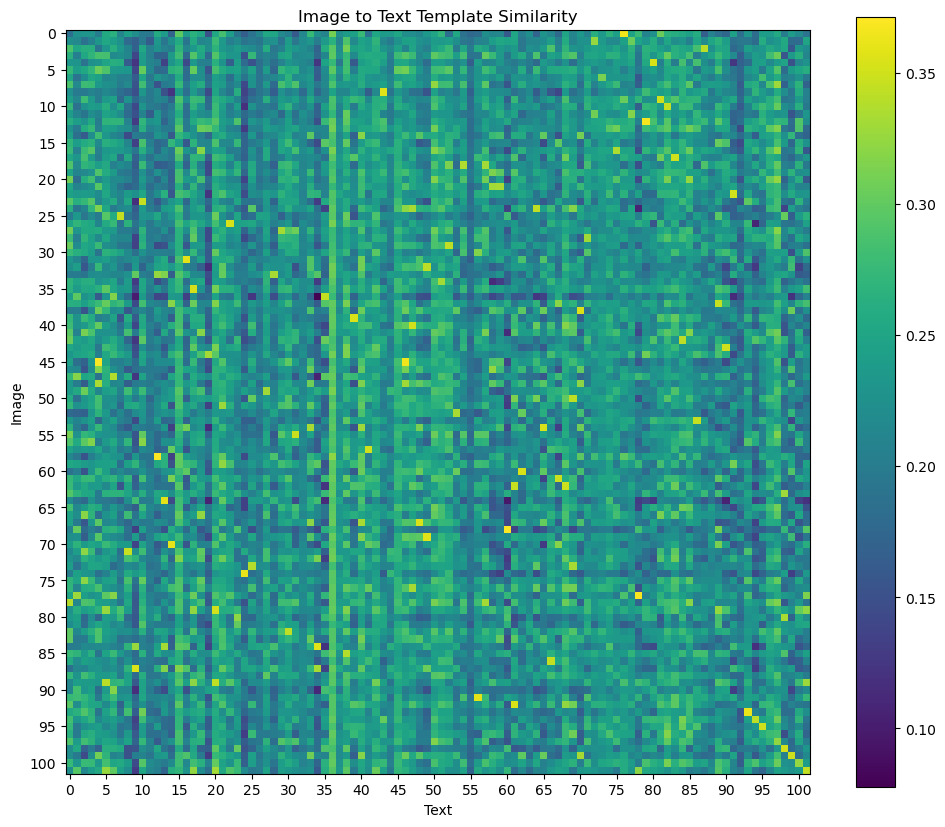

Image to text template similarity (individual) mean: 0.210280641913414
Image to text template similarity (individual) std: 0.034066684544086456
Image to text template similarity (individual) diagonal mean: 0.21897798776626587
Image to text template similarity (individual) diagonal std: 0.043963607400655746
Image to text template similarity (individual) non-diagonal mean: 0.21019452810287476
Image to text template similarity (individual) non-diagonal std: 0.033943139016628265
Image to text template similarity (individual) diagonal mean to non-diagonal mean ratio: 1.0417872667312622
Rank 1: (68)windflower - (60)cautleya spicata, Similarity: 0.344482421875
Rank 2: (77)lotus - (78)toad lily, Similarity: 0.343505859375
Rank 3: (12)king protea - (79)anthurium, Similarity: 0.339599609375
Rank 4: (0)pink primrose - (76)passion flower, Similarity: 0.334716796875
Rank 5: (58)orange dahlia - (12)king protea, Similarity: 0.333251953125
Rank 6: (45)wallflower - (4)english marigold, Similarity: 0.33

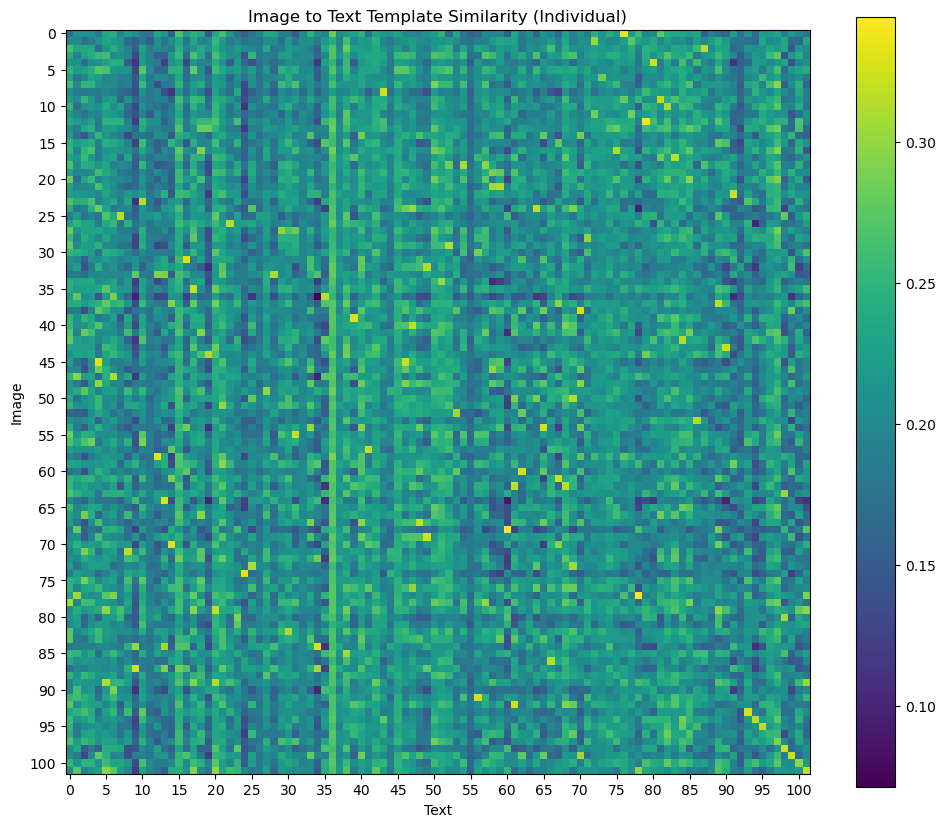

Image to original gpt-3 text similarity mean: 0.2371826171875
Image to original gpt-3 text similarity std: 0.040679931640625
Image to original gpt-3 text similarity diagonal mean: 0.247802734375
Image to original gpt-3 text similarity diagonal std: 0.049285888671875
Image to original gpt-3 text similarity non-diagonal mean: 0.237060546875
Image to original gpt-3 text similarity non-diagonal std: 0.040557861328125
Image to original gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.044921875
Rank 1: (68)windflower - (60)cautleya spicata, Similarity: 0.38671875
Rank 2: (77)lotus - (78)toad lily, Similarity: 0.384033203125
Rank 3: (26)prince of wales feathers - (22)fritillary, Similarity: 0.3818359375
Rank 4: (71)azalea - (8)monkshood, Similarity: 0.378662109375
Rank 5: (87)cyclamen - (9)globe thistle, Similarity: 0.3779296875
Rank 6: (33)mexican aster - (28)artichoke, Similarity: 0.37548828125
Rank 7: (12)king protea - (79)anthurium, Similarity: 0.374755859375
Rank 8: (0)p

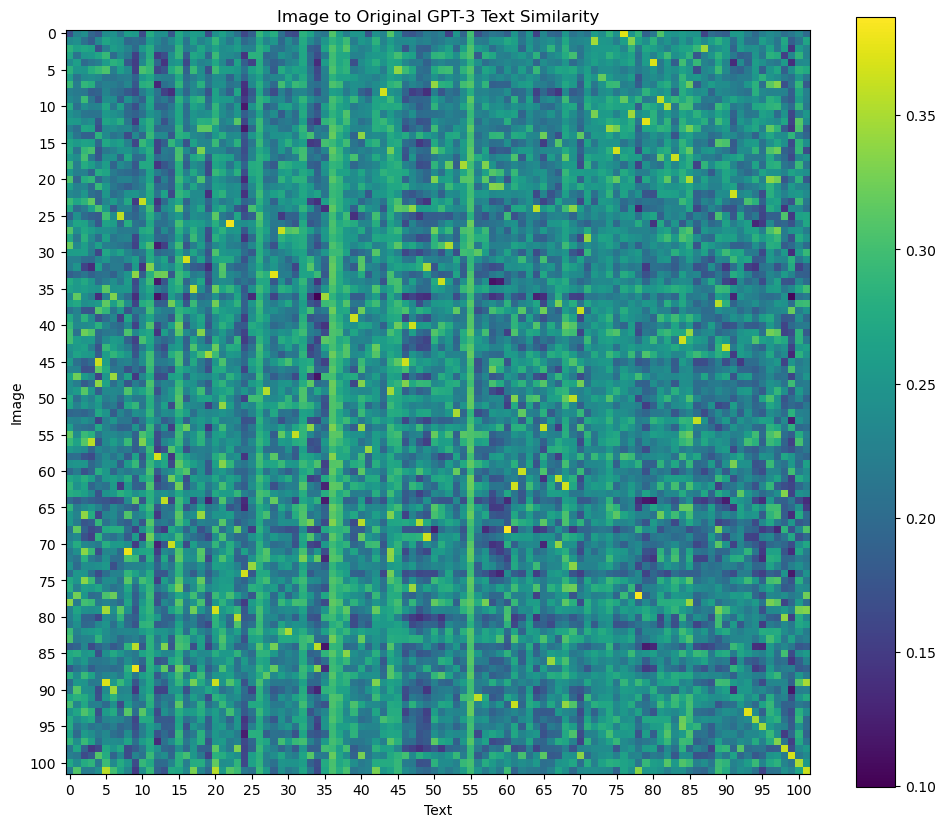

Image to original gpt-3 text similarity (individual) mean: 0.224113330245018
Image to original gpt-3 text similarity (individual) std: 0.03712676092982292
Image to original gpt-3 text similarity (individual) diagonal mean: 0.2344372272491455
Image to original gpt-3 text similarity (individual) diagonal std: 0.04684234783053398
Image to original gpt-3 text similarity (individual) non-diagonal mean: 0.2240111082792282
Image to original gpt-3 text similarity (individual) non-diagonal std: 0.037003424018621445
Image to original gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.0465428829193115
Rank 1: (26)prince of wales feathers - (22)fritillary, Similarity: 0.364990234375
Rank 2: (77)lotus - (78)toad lily, Similarity: 0.361328125
Rank 3: (74)thorn apple - (24)grape hyacinth, Similarity: 0.35986328125
Rank 4: (0)pink primrose - (76)passion flower, Similarity: 0.359619140625
Rank 5: (12)king protea - (79)anthurium, Similarity: 0.358642578125
Rank 6: (58)orange 

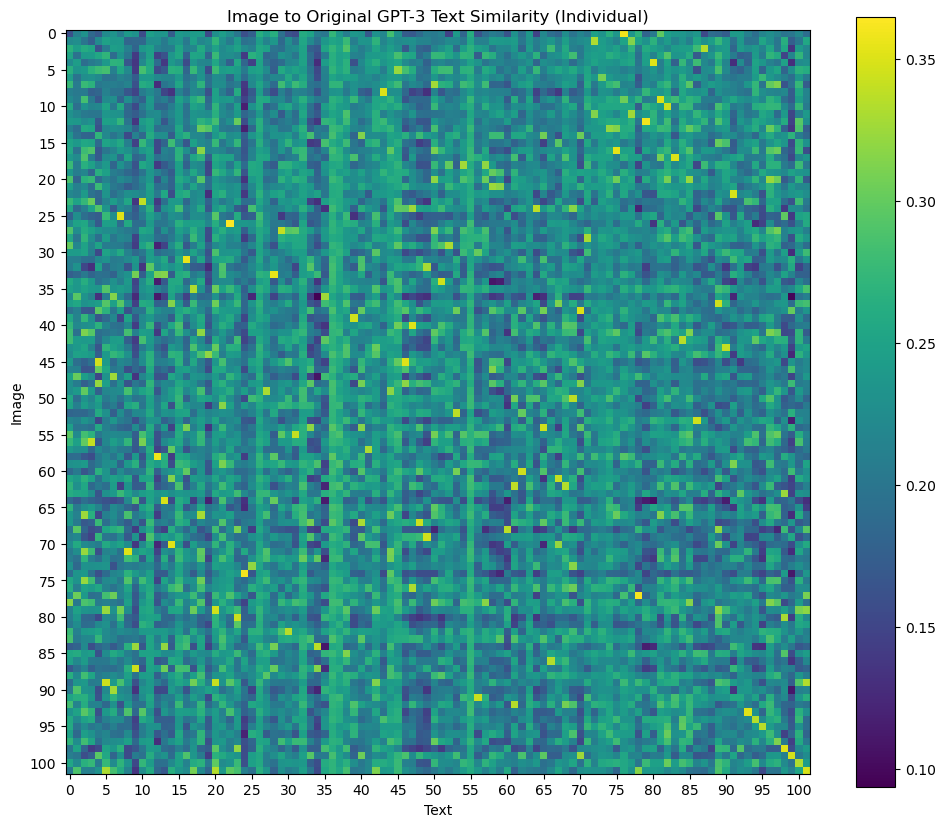

Image to filtered gpt-3 text similarity mean: 0.23583984375
Image to filtered gpt-3 text similarity std: 0.041290283203125
Image to filtered gpt-3 text similarity diagonal mean: 0.2464599609375
Image to filtered gpt-3 text similarity diagonal std: 0.0501708984375
Image to filtered gpt-3 text similarity non-diagonal mean: 0.23583984375
Image to filtered gpt-3 text similarity non-diagonal std: 0.041168212890625
Image to filtered gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.044921875
Rank 1: (77)lotus - (78)toad lily, Similarity: 0.384033203125
Rank 2: (26)prince of wales feathers - (22)fritillary, Similarity: 0.3818359375
Rank 3: (71)azalea - (8)monkshood, Similarity: 0.378662109375
Rank 4: (87)cyclamen - (9)globe thistle, Similarity: 0.375732421875
Rank 5: (12)king protea - (79)anthurium, Similarity: 0.374755859375
Rank 6: (33)mexican aster - (28)artichoke, Similarity: 0.37451171875
Rank 7: (0)pink primrose - (76)passion flower, Similarity: 0.373291015625
Rank 8: (9

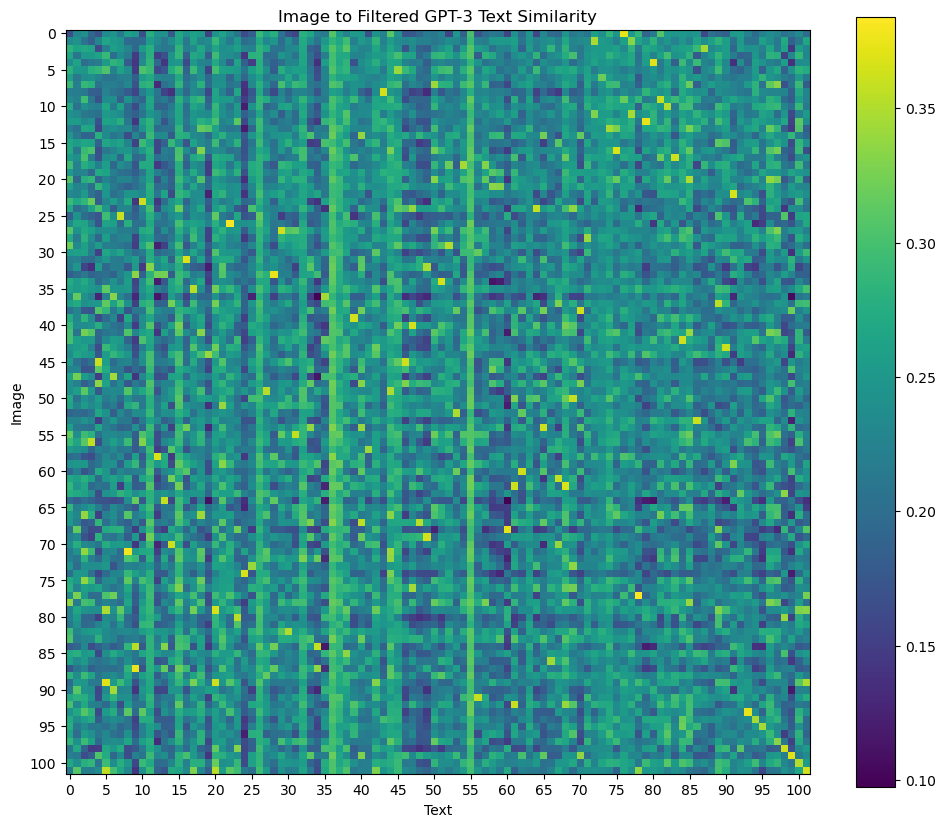

Image to filtered gpt-3 text similarity (individual) mean: 0.2240312397480011
Image to filtered gpt-3 text similarity (individual) std: 0.0378136970102787
Image to filtered gpt-3 text similarity (individual) diagonal mean: 0.23422540724277496
Image to filtered gpt-3 text similarity (individual) diagonal std: 0.04731535539031029
Image to filtered gpt-3 text similarity (individual) non-diagonal mean: 0.22393032908439636
Image to filtered gpt-3 text similarity (individual) non-diagonal std: 0.037693873047828674
Image to filtered gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.0459744930267334
Rank 1: (26)prince of wales feathers - (22)fritillary, Similarity: 0.364990234375
Rank 2: (77)lotus - (78)toad lily, Similarity: 0.361328125
Rank 3: (74)thorn apple - (24)grape hyacinth, Similarity: 0.35986328125
Rank 4: (0)pink primrose - (76)passion flower, Similarity: 0.359619140625
Rank 5: (12)king protea - (79)anthurium, Similarity: 0.358642578125
Rank 6: (33)mexic

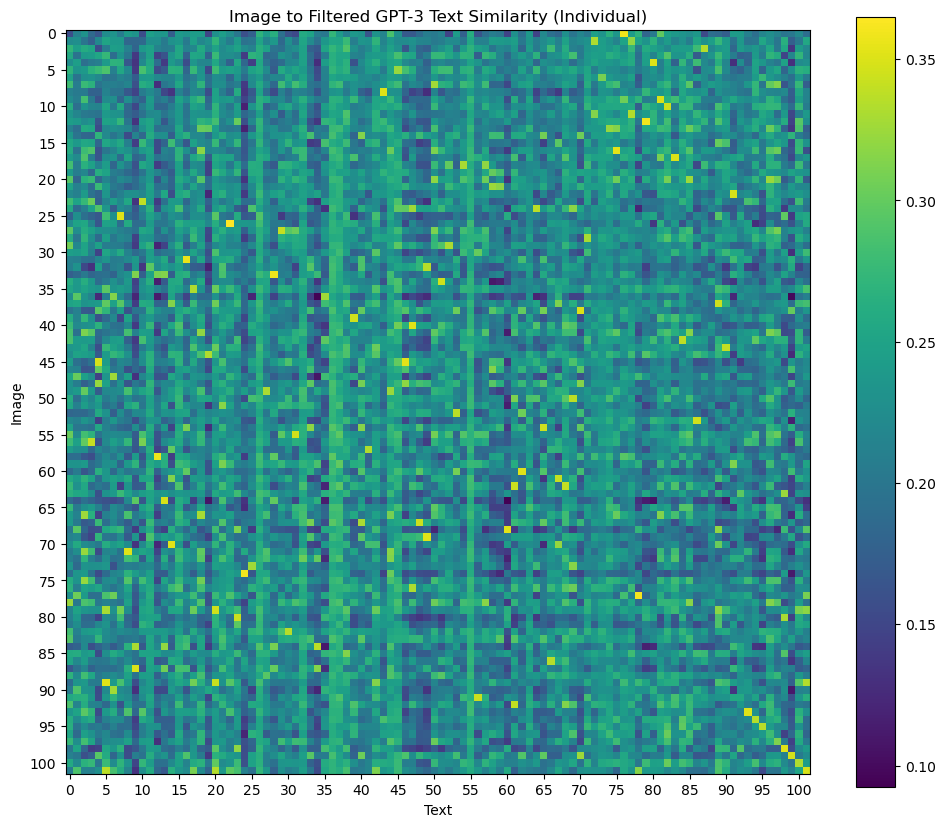

In [24]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image Similarity')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, 'Image to Class Name Similarity')
visualize_cross_similarity(img_template_cls_similarity, 'Image to Text Template Similarity')
visualize_cross_similarity(img_template_text_similarity, 'Image to Text Template Similarity (Individual)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, 'Image to Original GPT-3 Text Similarity')
visualize_cross_similarity(img_original_gpt3_text_similarity, 'Image to Original GPT-3 Text Similarity (Individual)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, 'Image to Filtered GPT-3 Text Similarity')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, 'Image to Filtered GPT-3 Text Similarity (Individual)')

In [25]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [26]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [27]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (50)petunia - (97)mexican petunia, Similarity: 0.88720703125
Rank 2: (4)english marigold - (46)marigold, Similarity: 0.8837890625
Rank 3: (25)corn poppy - (69)tree poppy, Similarity: 0.8828125
Rank 4: (85)tree mallow - (96)mallow, Similarity: 0.8818359375
Rank 5: (5)tiger lily - (20)fire lily, Similarity: 0.84521484375
Rank 6: (20)fire lily - (42)sword lily, Similarity: 0.84375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.8408203125
Rank 8: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.83447265625
Rank 9: (3)sweet pea - (47)buttercup, Similarity: 0.83447265625
Rank 10: (3)sweet pea - (73)rose, Similarity: 0.8251953125


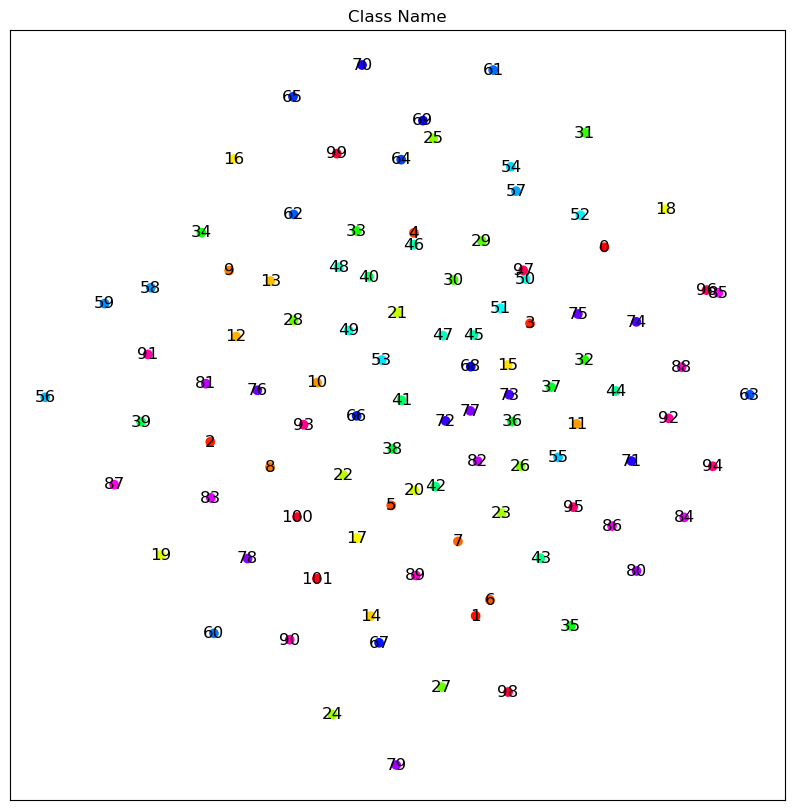

Rank 1: (4)english marigold - (46)marigold, Similarity: 0.95703125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.94384765625
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.890625
Rank 4: (25)corn poppy - (69)tree poppy, Similarity: 0.8818359375
Rank 5: (20)fire lily - (42)sword lily, Similarity: 0.87841796875
Rank 6: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.86865234375
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.86376953125
Rank 8: (5)tiger lily - (20)fire lily, Similarity: 0.85107421875
Rank 9: (36)cape flower - (73)rose, Similarity: 0.8486328125
Rank 10: (72)water lily - (77)lotus, Similarity: 0.8447265625


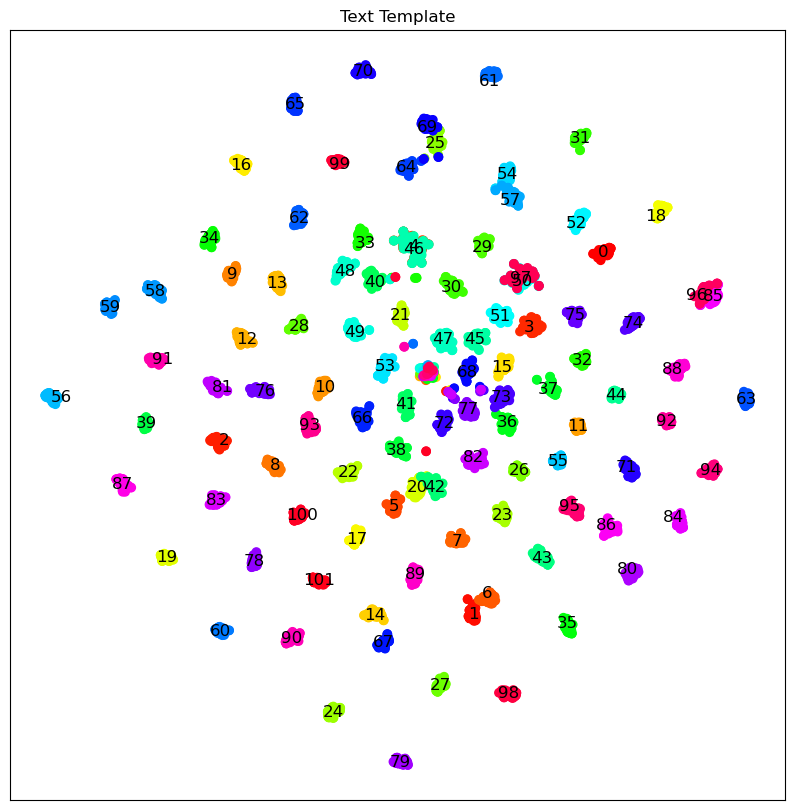

Rank 1: (4)english marigold - (46)marigold, Similarity: 0.978515625
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.94677734375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8984375
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8955078125
Rank 7: (54)pelargonium - (57)geranium, Similarity: 0.89501953125
Rank 8: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 9: (5)tiger lily - (20)fire lily, Similarity: 0.888671875
Rank 10: (20)fire lily - (42)sword lily, Similarity: 0.8818359375


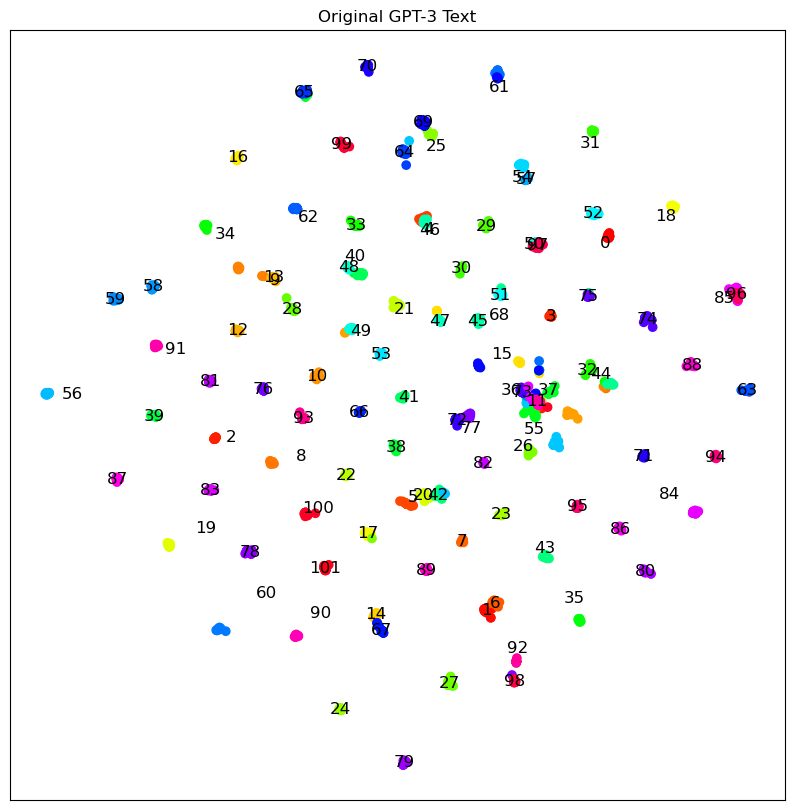

Rank 1: (4)english marigold - (46)marigold, Similarity: 0.97705078125
Rank 2: (50)petunia - (97)mexican petunia, Similarity: 0.95703125
Rank 3: (85)tree mallow - (96)mallow, Similarity: 0.9443359375
Rank 4: (1)hard-leaved pocket orchid - (6)moon orchid, Similarity: 0.91455078125
Rank 5: (72)water lily - (77)lotus, Similarity: 0.8955078125
Rank 6: (25)corn poppy - (69)tree poppy, Similarity: 0.8935546875
Rank 7: (14)yellow iris - (67)bearded iris, Similarity: 0.88916015625
Rank 8: (54)pelargonium - (57)geranium, Similarity: 0.8876953125
Rank 9: (20)fire lily - (42)sword lily, Similarity: 0.8818359375
Rank 10: (5)tiger lily - (20)fire lily, Similarity: 0.880859375


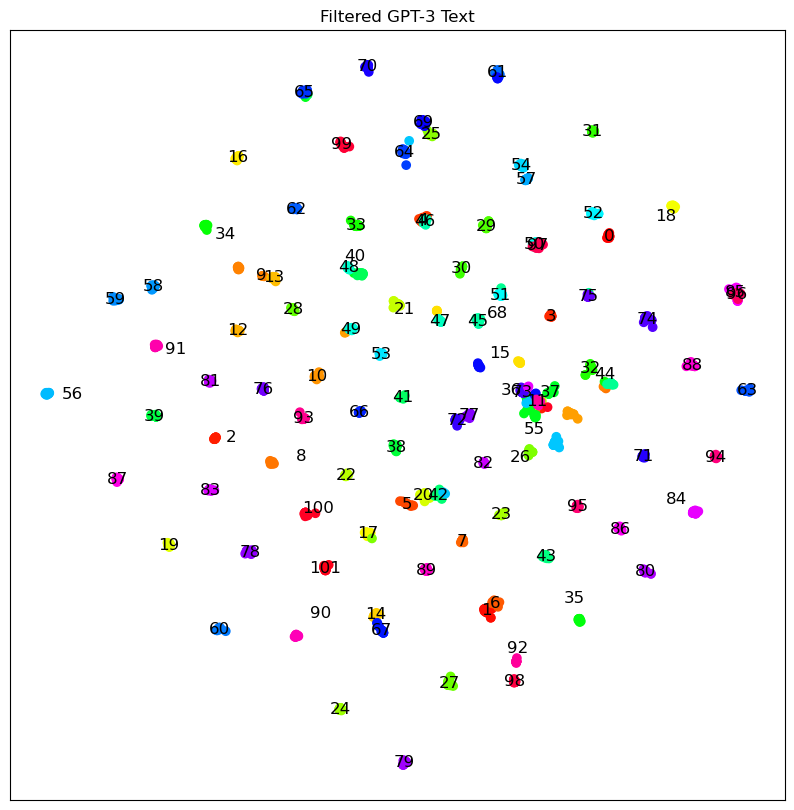

In [28]:
print_top_similarity(np.triu(cls_name_masked_similarity, k=1))
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_similarity(np.triu(template_masked_similarity, k=1))
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_similarity(np.triu(original_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_similarity(np.triu(filtered_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')